# Анализ данных и построение модели

В этом ноутбуке будут проанализированы данные, собранные и обработанные в предыдущих частях и построена модель машинного обучения, предсказывающая цену инструмента.

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.feature_selection import mutual_info_classif as MIC
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')
import re

## Анализ данных

In [110]:
df = pd.read_csv('musik_productiv_df_processed')

In [111]:
df.columns

Index(['Цена', 'Дека', 'Конструкция', 'Конструкция грифа', 'Мензура',
       'Длина мензуры', 'Накладка грифа', 'Количество ладов', 'Число струн',
       'Типы звукоснимателей', 'Страна производства', 'Звукосниматель грифа',
       'Бриджевый звукосниматель', 'Встроенная электроника',
       'Средний звукосниматель', 'Бренд', 'Модель', 'Материал корпуса',
       'Материал корпуса_2', 'Материал корпуса_3', 'Кол-во слоев', 'Гриф_1',
       'Гриф_2', 'Гриф_3', 'Гриф_4', 'Гриф_5', 'Гриф_6'],
      dtype='object')

Сперва посмотрим на среднюю цену каждого бренда.

In [112]:
df_brand_pivot = df.groupby('Бренд')['Цена'].median().sort_values().reset_index()

<AxesSubplot:xlabel='Бренд', ylabel='Цена'>

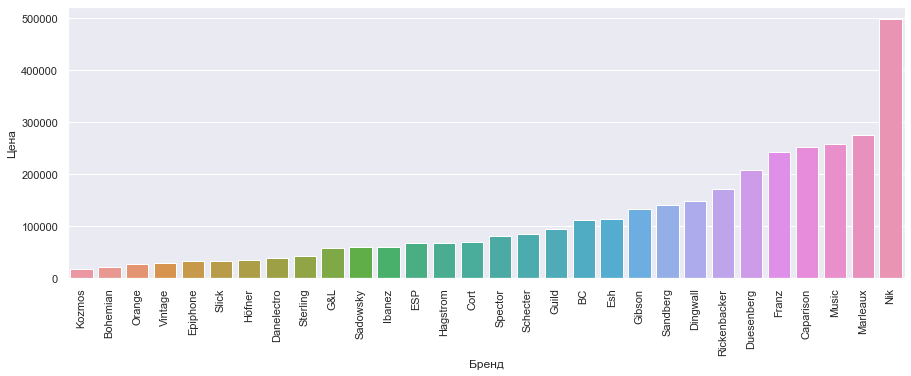

In [113]:
sns.set(rc = {'figure.figsize' : (15, 5)})
plt.xticks(rotation=90)
sns.barplot(x = df_brand_pivot['Бренд'], y = df_brand_pivot['Цена'])

Сравнение средних ничего не говорит о наличии статистически значитмых различий между брендами, однако в данном случае автору интреесна общая картина цен на рынке. В итоге среди первой пятерки усредненных цен среди самых дорогих и самых дешевых инструментов почти не оказалось известных брендов - среди них широко известен только бренд "Music", полное название которого "Music Man". Возможно, что бренды не знакомы потому что магазин находится в Германии, и эти бренды не представлены в России официально. Также интересной особенностью данного магазина является то, что они не продают один из самых известных и старых брендов музыкальных инструментов - Fender. Странно выглядят бренды "G&L" и "Sadowsky" среди недорогих инструментов - это дорогие бренды и как правило они выпускают дорогую продукцию, однако судя по всему в данном магазине представлены только недорогие инструменты либо можно предположить, что в Германии эти инструменты стоят значительно дешевле, чем в России.

Посмотрим на среднюю цену инструментов в зависимости от материала корпуса

In [114]:
df_body_pivot = df.groupby('Материал корпуса')['Цена'].median().sort_values().reset_index()

<AxesSubplot:xlabel='Материал корпуса', ylabel='Цена'>

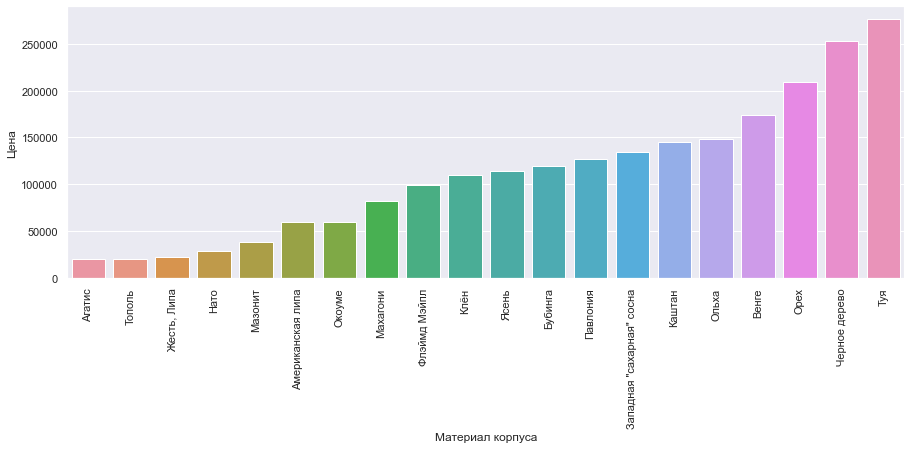

In [115]:
plt.xticks(rotation=90)
sns.barplot(x = df_body_pivot['Материал корпуса'], y = df_body_pivot['Цена'])

Из популярных пород дерева самой дешевой ожидаемо оказалась Липа, по середине ценовых средних оказались Махагони, Клен, Ясень, а самой дорогой - Ольха.

## Проверка статистической гипотезы

In [116]:
df['Число струн'].value_counts()

4    373
5    197
6     24
8      5
7      1
Name: Число струн, dtype: int64

Самыми популярными являются четырех и пятиструнные бас-гитары. Проверим есть-ли статистическизначимые различия между средними ценами этих инструментов.

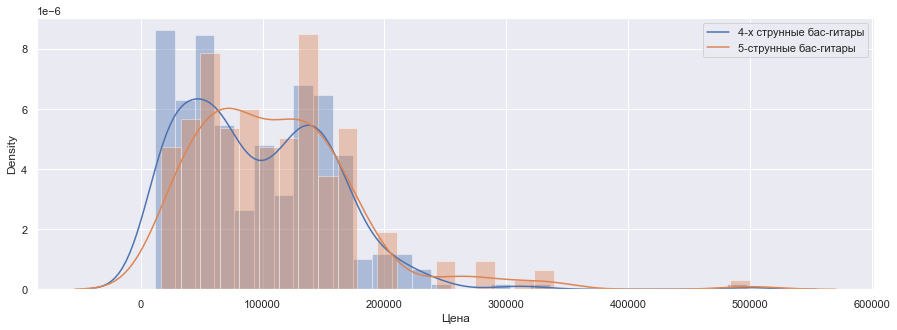

In [117]:
sns.distplot(df[df['Число струн'] == 4]['Цена'], bins = 30)
sns.distplot(df[df['Число струн'] == 5]['Цена'], bins = 30)
plt.legend(labels=["4-х струнные бас-гитары", "5-струнные бас-гитары"])

Графики распределения цен очень похожи, однозначного вывода сделать нельзя, посмотрим на диаграмму размаха.

<AxesSubplot:xlabel='Число струн', ylabel='Цена'>

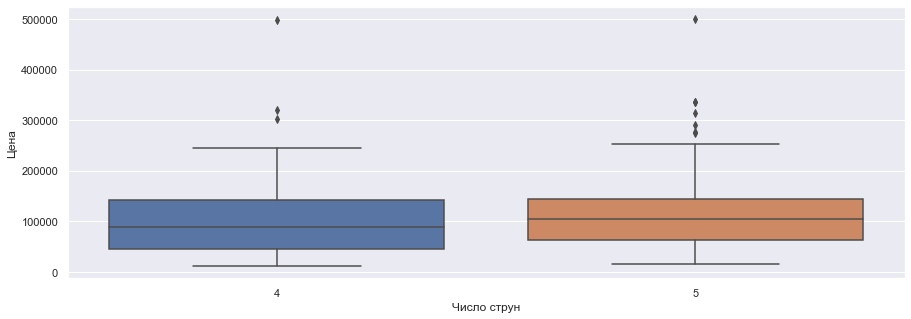

In [118]:
sns.boxplot(x = 'Число струн', y = 'Цена', data = df[df['Число струн'] < 6])

Среди 5-струнных инструментов встречается больше выбросов и среднее значение цены выше, однако границы второго и четвертого квартиля находятся внутри границ второго и четвертого квартиля 4-х струнных бас-гитар. Для определения наличия или отсутствия статистически значимых различий между ценами на 4-х и 5-ти струнные бас-гитары необходимо провести тест. Исходя из графика распределения, можно установить, что данные распределены нормальным образом - подойдет t-test.

Сформурируем 2 гипотезы:
Нулевая: между ценами на четырех и пятиструнные инструменты различий нет
Альтернативная: между ценами на четырех и пятиструнные инструменты различия есть - пятиструнные инструменты дороже. За пороговое значение p-value возьмем 0.05.

In [119]:
four_str = df[df['Число струн'] == 4]['Цена']
five_str = df[df['Число струн'] == 5]['Цена']

result = st.ttest_ind(four_str, five_str).pvalue
print('p-value:', result)
if result < 0.05 and five_str.mean() > four_str.mean():
    print('Альтернативная гипотеза, скорее всего, верна')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-value: 0.012410611996955924
Альтернативная гипотеза, скорее всего, верна


Проведя статистический тест мы пришли к выводу, что статистически значимые отличия между ценами на четырех и пятиструнные инструменты, скорре всего, есть - пятиструнные инструменты дороже.

## Построение модели машинного обучения

Применим технику "One hot encoding" к категориальным признакам

In [120]:
df_ohe = pd.get_dummies(df, drop_first = True)

Разобьем данные на обучающую и тестовую выборки.

In [121]:
train, test = train_test_split(df_ohe, test_size = 0.2, random_state = 792)

In [122]:
features_train = train.drop('Цена', axis =1)
features_test = test.drop('Цена', axis =1)
target_train = train['Цена']
target_test = test['Цена']

Проверим количественные признаки на мультиколлинеарность.

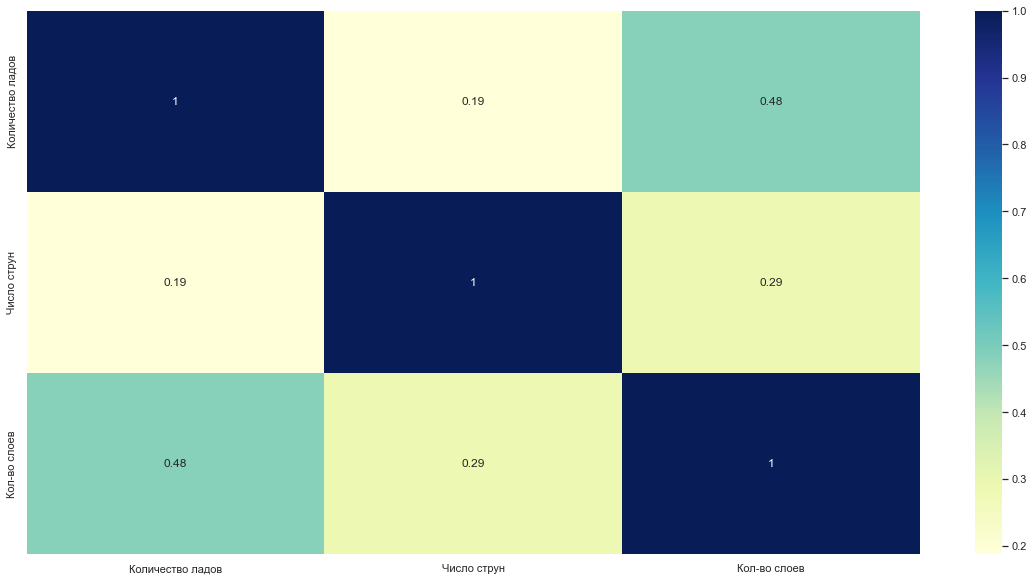

In [123]:
plt.figure(figsize = (20, 10))
dataplot = sns.heatmap(features_train[['Количество ладов', 'Число струн', 'Кол-во слоев']].corr(), cmap="YlGnBu", annot=True)

Колличественные признаки не сильно коррелируют между собой - оставим датафрейм без изменений на этом этапе.

Поученный датафрейм получился обень большим из-за огромного количества признаков - проверим какие признаки важны для определения таргета, а какие - нет и уберем лишнее. Для этого используем инструмент mutual_info_classif из библиотеки sklearn.

In [124]:
MIC_data = pd.DataFrame({'feature' : list(features_train.columns), 'MIC' : list(MIC(features_train, target_train))})
MIC_data = MIC_data.sort_values('MIC', ascending = False)

In [125]:
MIC_data

,feature,MIC
576,Материал корпуса_2_Нет,3.189180
41,Конструкция_Солид Бади,3.051742
578,Материал корпуса_3_Нет,2.871460
31,Дека_Тополь,2.191972
581,Гриф_1_клен,2.175267
...,...,...
404,Бренд_Höfner,0.000000
180,Звукосниматель грифа_Ибанез Дайнэмикс Джей Нек,0.000000
402,Бренд_Guild,0.000000
185,Звукосниматель грифа_Ибанез клэссик элит,0.000000


В значениях есть признаки с нулевым значением MIC - уберем эти признаки.

In [126]:
MIC_data_cut = MIC_data[MIC_data['MIC'] > 0]
MIC_data_cut

,feature,MIC
576,Материал корпуса_2_Нет,3.189180
41,Конструкция_Солид Бади,3.051742
578,Материал корпуса_3_Нет,2.871460
31,Дека_Тополь,2.191972
581,Гриф_1_клен,2.175267
...,...,...
208,Звукосниматель грифа_Фишмэн Флюэнс,0.001867
494,Модель_SDB3-PW,0.000926
255,Бриджевый звукосниматель_H5 специального дизай...,0.000679
417,Бренд_Sterling,0.000501


В данных стало на 272 признака меньше. Признаков все еще очень много - в градиентный бустинг такой датафрейм не поместится - попробуем убрать еще больше данных (оставить только те, где значение MIC больше квантиля 0.8) и обучить модель на получившихся данных. Если значение r2 будет больше 0.85 - оставим без изменений.

In [127]:
MIC_data_cut = MIC_data[MIC_data['MIC'] > MIC_data['MIC'].quantile(0.8)]
MIC_data_cut

,feature,MIC
576,Материал корпуса_2_Нет,3.189180
41,Конструкция_Солид Бади,3.051742
578,Материал корпуса_3_Нет,2.871460
31,Дека_Тополь,2.191972
581,Гриф_1_клен,2.175267
...,...,...
462,Модель_Gio,0.067095
23,Дека_Мэйзонайт,0.066219
496,Модель_SLPB,0.065975
251,Бриджевый звукосниматель_G&amp;L MFD™ хамбакер,0.065577


In [128]:
features_train = features_train[list(MIC_data_cut['feature'])]
features_test = features_test[list(MIC_data_cut['feature'])]

### Случайный лес

In [129]:
params = {
    'n_estimators' : [50, 70, 100],
    'max_depth' : [1, 5, 20, 50, 75]
}

In [130]:
grid = GridSearchCV(RandomForestRegressor(random_state = 792), params, scoring='neg_mean_squared_error', cv=5)
RandomForestRegressor_best_result = grid.fit(features_train, target_train)

In [131]:
RandomForestRegressor_best_result = grid.best_estimator_
print('Лучшие параметры случайного леса:', RandomForestRegressor_best_result)

Лучшие параметры случайного леса: RandomForestRegressor(max_depth=20, n_estimators=50, random_state=792)


In [132]:
predictions_RandomForestRegressor = RandomForestRegressor_best_result.predict(features_test)

In [133]:
rmse_test_RandomForestRegressor = mean_squared_error(target_test, predictions_RandomForestRegressor) ** 0.5
r2_test_RandomForestRegressor = r2_score(target_test, predictions_RandomForestRegressor)

In [134]:
print('Результат R2 на тестовой выборке: ', r2_score(target_test, predictions_RandomForestRegressor))
print('Результат RMSE на тестовой выборке: ', rmse_test_RandomForestRegressor)

Результат R2 на тестовой выборке:  0.8959108543372198
Результат RMSE на тестовой выборке:  16148.639351371407


### Градиентный бустинг

In [135]:
category = list(features_train.columns.drop(['Количество ладов', 'Число струн', 'Кол-во слоев']))
features_train[category] = features_train[category].astype('category')
features_test[category] = features_test[category].astype('category')

In [136]:
features_train

,Материал корпуса_2_Нет,Конструкция_Солид Бади,Материал корпуса_3_Нет,Дека_Тополь,Гриф_1_клен,Конструкция грифа_Закреплён винтами,Средний звукосниматель_Нет,Длина мензуры_34,Кол-во слоев,Число струн,...,Средний звукосниматель_G&amp;L L-спек G&amp;L MFD™ Хамбакер,Модель_SR506E-BM,Звукосниматель грифа_Ибанез Клэссик Элит Басс,Модель_Iron,Бриджевый звукосниматель_Хамбакер Мьюзик Мэн с неодимовыми магнитами,Модель_Gio,Дека_Мэйзонайт,Модель_SLPB,Бриджевый звукосниматель_G&amp;L MFD™ хамбакер,Звукосниматель грифа_Фишмэн Флюэнс SB-1
27,1,1,1,1,1,1,0,1,1,4,...,0,0,0,0,0,0,0,1,0,0
397,1,1,1,1,1,1,1,0,1,4,...,0,0,0,0,0,0,0,0,0,0
189,1,1,1,1,1,1,1,1,1,5,...,0,0,0,0,0,0,0,0,0,0
417,1,1,1,1,1,0,1,0,1,4,...,0,0,0,0,0,0,0,0,0,0
62,1,1,1,1,1,1,0,1,1,4,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,1,1,1,1,1,1,1,0,5,5,...,0,0,0,0,0,0,0,0,0,0
34,1,1,1,0,1,1,1,1,5,4,...,0,0,0,0,0,0,0,0,0,0
252,1,1,1,1,1,1,1,1,1,5,...,0,0,0,0,0,0,0,0,0,0
399,1,1,1,0,0,1,0,1,5,5,...,0,0,0,0,0,0,0,0,0,0


In [137]:
features_train = features_train.rename(columns = lambda x:re.sub('[^А-Яа-яA-Za-z0-9_]+', '', x))

In [138]:
params = {
    'learning_rate': [0.1, 0.03, 0.001],
    'n_estimators': [50, 100, 400, 500, 700, 1000],
}

In [139]:
gb = GridSearchCV(lgb.LGBMRegressor(random_state=792), params, cv=3)
LGBMRegressor_best_result = gb.fit(features_train, target_train)

In [140]:
LGBMRegressor_best_result = gb.best_estimator_
LGBMRegressor_best_result

LGBMRegressor(random_state=792)

In [141]:
predictions_lgb = LGBMRegressor_best_result.predict(features_test)

In [142]:
r2_test_lgb = r2_score(target_test, predictions_lgb)
rmse_test_lgb = mean_squared_error(target_test, predictions_lgb) ** 0.5

In [143]:
print('Результат R2 на тестовой выборке: ', r2_test_lgb)
print('Результат RMSE на тестовой выборке: ', rmse_test_lgb)

Результат R2 на тестовой выборке:  0.8406727182632657
Результат RMSE на тестовой выборке:  19979.208857359194


## Выводы

In [145]:
results = pd.DataFrame({
    'Случайный лес' : [r2_test_RandomForestRegressor.round(2), rmse_test_RandomForestRegressor.round(2)],
    'Градиентный бустинг' : [r2_test_lgb.round(2), rmse_test_lgb.round(2)]
})
results

,Случайный лес,Градиентный бустинг
0,0.90,0.84
1,16148.64,19979.21


В результате модель "Случайный лес" показала лучший результатат - модель ошибается в среднем на 16148,64 рубля. Для более точного прогноза цены не хватает данных для обучения - выборка в 600 инструментов не достаточно большая, в качестве улучшения модели имеет смысл добавить данные из других источников - других интернет-магазинов. Если такой проект будет реализован, то будет добавлен к этому проекту в качестве четвертой части.